In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# On the Docket:

### Stub Strategy (Equal weighted portf)
### Backtesting infrastructure
### Other implementations --> Risk Parity, MV allocation, Weighted MV allocation, mixing previous strategies w/ weights
### Optimization sharpe ratio in levels (window size, strategy, rebalancing rate).

In [32]:
# Fetching Data

data = pd.read_csv('Case2.csv')
TRAIN, TEST = train_test_split(data, test_size = 0.2, shuffle = False)

np.shape(TEST)

(7800, 6)

## Stub Code

0.010993821121174302


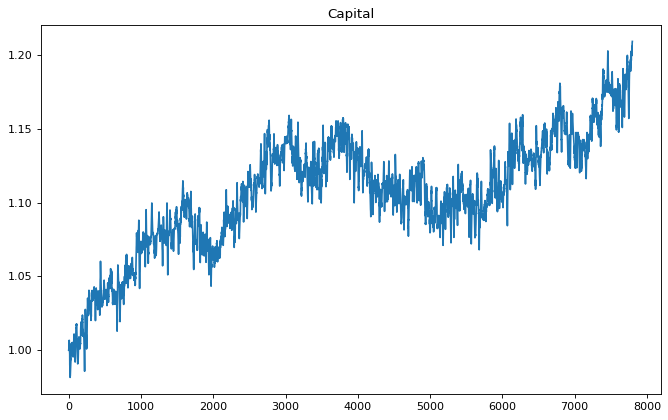

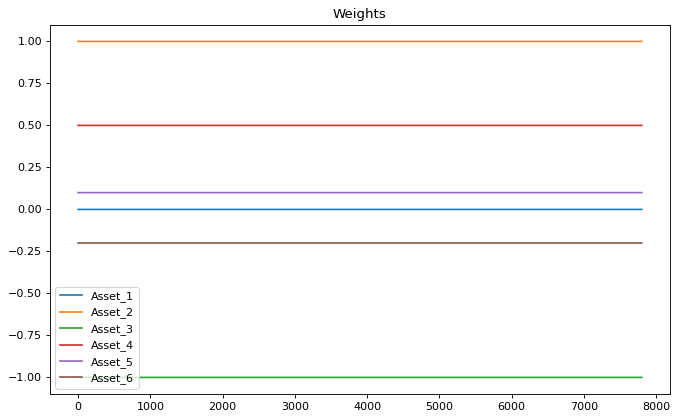

In [68]:
'''
We recommend that you change your train and test split
'''

#TRAIN, TEST = train_test_split(data, test_size = 0.2, shuffle = False)


# Change init variables and allocate method in order to change behavior of the allocations.

class Allocator():
    def __init__(self, train_data):
        '''
        Anything data you want to store between days must be stored in a class field
        '''
        
        self.running_price_paths = train_data.copy()
        
        self.train_data = train_data.copy()
        
        # Do any preprocessing here -- do not touch running_price_paths, it will store the price path up to that data
        
        
    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        new_row = pd.DataFrame([asset_prices], columns=self.running_price_paths.columns)
        self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)

    
        ### TODO Implement your code here
        weights = np.array([0,1,-1,0.5,0.1,-0.2])
        
        return weights


def grading(train_data, test_data): 
    '''
    Grading Script
    '''
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = Allocator(train_data)
    for i in range(0,len(test_data)):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")
    
    capital = [1]
    for i in range(len(test_data) - 1):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]
    
    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0
        
    return sharpe, capital, weights

sharpe, capital, weights = grading(TRAIN, TEST)
#Sharpe gets printed to command line
print(sharpe)

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Capital")
plt.plot(np.arange(len(TEST)), capital)
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Weights")
plt.plot(np.arange(len(TEST)), weights)
plt.legend(TEST.columns)
plt.show()

## Equal Weighted Portfolio

In [34]:
class Equal_Allocator(Allocator):

    def __init__(self, train_data):
        super().__init__(train_data)
        self.excess_returns = self.running_price_paths.pct_change()

    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        new_row = pd.DataFrame([asset_prices], columns=self.running_price_paths.columns)
        self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)

    
        ### TODO Implement your code here
        weights = np.ones(6)
        weights = weights / 6
        
        return weights

## Risk-Parity Allocation

### Inverse Vol Matrix --> Fast, somewhat inaccurate, good for daily.

In [35]:
class Inverse_Vol_Alloc(Allocator):
    
    def __init__(self, train_data):
        '''
        Store price history and initialize parameters
        '''
        super().__init__(train_data)
        self.excess_returns = self.running_price_paths.pct_change()
        
        self.lookback_window = 900
        self.current_weights = np.ones(6) / 6

    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        new_row = pd.DataFrame([asset_prices], columns=self.running_price_paths.columns)
        self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)
        new_excess_returns = pd.DataFrame(self.running_price_paths.iloc[-2:].pct_change().dropna())
        self.excess_returns = pd.concat([self.excess_returns, new_excess_returns], ignore_index=True)
    
        ### TODO Implement your code here
        
        cov_matrix = self.excess_returns.iloc[-self.lookback_window:].cov()
        vol = np.sqrt(np.diag(cov_matrix))     # Get standard deviations
        inv_vol = 1 / vol                      # Inverse volatility
        weights = inv_vol / np.sum(inv_vol)   # Normalize

        return weights

### True Risk Parity --> Slow, accurate, good for long-term

Doesn't work lmaoooo

In [36]:
from scipy.optimize import minimize

class Risk_Parity_Alloc(Allocator):
    
    def __init__(self, train_data):
        '''
        Store price history and initialize parameters
        '''
        self.running_price_paths = train_data.copy()

        self.excess_returns = self.running_price_paths.pct_change()
        
        self.train_data = train_data.copy()
        
        self.rebalance_freq = 150    # Rebalance every N ticks
        self.tick_counter = 0
        self.current_weights = np.ones(6) / 6

    def risk_contributions(self, weights, cov_matrix):
        port_var = weights.T @ cov_matrix @ weights
        marginal = cov_matrix @ weights
        total_contrib = weights * marginal
        return total_contrib / np.sqrt(port_var)
    
    def risk_parity_objective(self, weights, cov_matrix):
        rc = self.risk_contributions(weights, cov_matrix)
        target = np.mean(rc)
        return np.sum((rc - target)**2)

    def risk_parity_weights(self, cov_matrix):
        n = cov_matrix.shape[0]
        x0 = np.array([1/n]*n)
        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        bounds = [(0, 1)] * n  # long-only; change to (-1, 1) for leverage
        
        result = minimize(self.risk_parity_objective, x0, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
        
        return result.x if result.success else x0


    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
    
        ### TODO Implement your code here

        new_row = pd.DataFrame([asset_prices], columns=self.running_price_paths.columns)
        self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)
        new_excess_returns = pd.DataFrame(self.running_price_paths.iloc[-2:].pct_change().dropna())
        self.excess_returns = pd.concat([self.excess_returns, new_excess_returns], ignore_index=True)
        
        if self.tick_counter % self.rebalance_freq != 0:
            self.tick_counter += 1
            return self.current_weights

        cov_matrix = self.excess_returns.cov()

        self.current_weights = self.risk_parity_weights(cov_matrix)

        self.tick_counter += 1

        return self.current_weights


## Mean Variance Allocation

In [129]:
class MV_Alloc():
    def __init__(self, train_data, rebalance_freq, window):
        '''
        Store price history and initialize parameters
        '''
        self.running_price_paths = train_data.copy()
        self.train_data = train_data.copy()
        self.lookback_window = window  # Number of ticks for rolling returns
        self.rebalance_freq = rebalance_freq    # Rebalance every N ticks
        self.tick_counter = 0
        
        # Initialize weights to equal weights
        self.current_weights = np.array([1/6] * 6)
        
        # Parameters for mean-variance optimization

    def calculate_rolling_er(self, prices, window):
        '''
        Calculate compounded rolling returns over specified window
        '''
        returns = prices.pct_change()
        rolling_rets = (1 + returns).rolling(window).apply(np.prod, raw=True) - 1
        excess_returns = rolling_rets.sub(rolling_rets.mean(axis=1), axis=0).dropna()
        
        return excess_returns
    
    def tangency_portfolio(self, mean_returns, cov_matrix):
        '''
        Compute tangency portfolio weights
        '''
        inverted_cov = np.linalg.pinv(cov_matrix) if np.isclose(np.linalg.det(cov_matrix), 0) else np.linalg.inv(cov_matrix)
        one_vector = np.ones(mean_returns.shape)
        return (inverted_cov @ mean_returns) / (one_vector @ inverted_cov @ mean_returns)
    
    def allocate_portfolio(self, asset_prices):
        self.tick_counter += 1

        # Add new prices directly to NumPy array instead of DataFrame for speed
        if isinstance(self.running_price_paths, pd.DataFrame):
            new_row = pd.DataFrame([asset_prices], columns=self.running_price_paths.columns)
            self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)
        else:
            self.running_price_paths = np.vstack([self.running_price_paths, asset_prices])

        # Only rebalance every N ticks
        if self.tick_counter % self.rebalance_freq != 0:
            return self.current_weights

        # Use only most recent window of data
        window = min(self.lookback_window, len(self.running_price_paths))
        prices = self.running_price_paths[-window:]

        # Compute returns (NumPy for speed)
        returns = np.diff(prices, axis=0) / prices[:-1]
        if returns.shape[0] < 2:
            return self.current_weights

        # Expected returns & covariance
        mu = np.mean(returns, axis=0)
        cov = np.cov(returns.T)

        # Tangency portfolio
        try:
            allocation = self.tangency_portfolio(mu, cov)

            # Target return scaling (optional)
            expected_return = mu @ allocation
            allocation *= 0.0075 / expected_return

            # Constraint to max leverage of 1
            max_leverage = 1.0 / np.max(np.abs(allocation))
            allocation *= max_leverage

            self.current_weights = allocation
        except Exception as e:
            print("Tangency portfolio failed:", e)
            self.current_weights = np.ones(6) / 6

        return self.current_weights

        

## Testing Section

0.013618095802140046


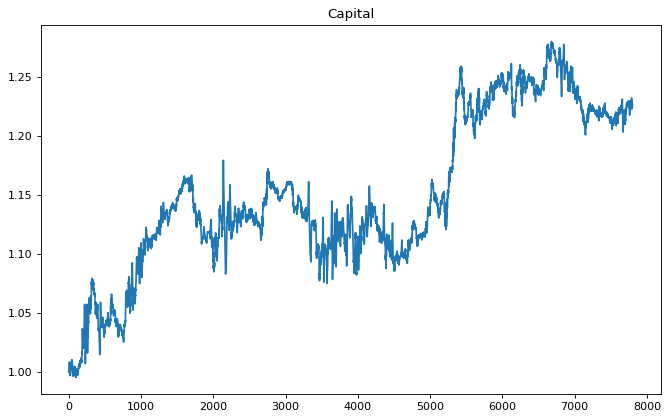

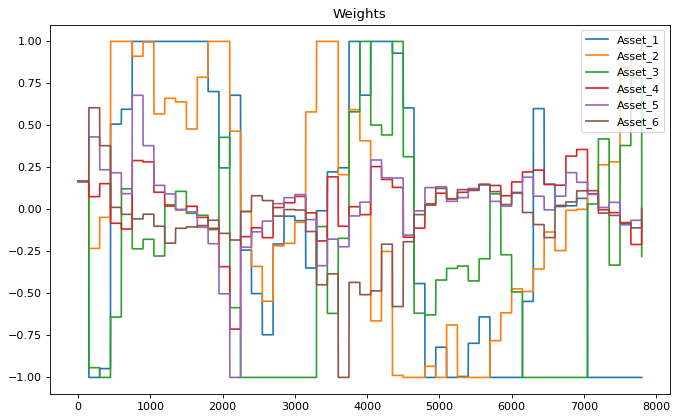

In [134]:
# Backtesting Code

data = pd.read_csv('Case2.csv')
TRAIN, TEST = train_test_split(data, test_size = 0.2, shuffle = False)

def grading_1(train_data, test_data, rebalance_freq, window): 
    '''
    Grading Script
    '''
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = MV_Alloc(train_data, 150, 900)
    for i in range(0,len(test_data)):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")
    
    capital = [1]
    for i in range(len(test_data) - 1):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]
    
    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0
        
    return sharpe, capital, weights

sharpe, capital, weights = grading_1(TRAIN, TEST, 150, 900)
#Sharpe gets printed to command line
print(sharpe)

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Capital")
plt.plot(np.arange(len(TEST)), capital)
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Weights")
plt.plot(np.arange(len(TEST)), weights)
plt.legend(TEST.columns)
plt.show()

In [198]:
import math
# sharpe_results_df = pd.DataFrame(sharpe_results)
# capital_results_df = pd.DataFrame(capital_results)
# weights_resuts_df = pd.DataFrame(weights_resuts)

# capital_results_df

sharpe_results_df = pd.read_csv("Case_2_Results\sharpe_results.csv")
capital_results_df = pd.read_csv("Case_2_Results\capital_results.csv")
weights_resuts_df = pd.read_csv("Case_2_Results\weights_results.csv")

adjusted_sharpe = sharpe_results_df
adjusted_sharpe['sharpe'] = adjusted_sharpe['sharpe'] * math.sqrt(7800)

max_id = adjusted_sharpe['sharpe'].idxmax()
print(max_id)
print(adjusted_sharpe['sharpe'].max())

1
2.1976020602552433


In [194]:
capital_results_df['capital'].max()

np.float64(1.0499996366532796)

## Help Notes

- Apply basic options and math
- Data is machine generated --> can use signal generation and machine learning easily for high sharpe ratios.


# New Strategy: Machine learning with Scikit learn and scipy

- Identify good vs. noisy assets
- Engineer features and forecast returns
- Plug predictions into MV or RP optimization
- Constrain + stabilize weights
- Maximize out-of-sample Sharpe

In [227]:
data = pd.read_csv('Case2.csv')
TRAIN, TEST = train_test_split(data, test_size = 0.2, shuffle = False)

## 1- Identify good vs. noisy assets

In [228]:
returns = TRAIN.pct_change().dropna()

rolling_mean = returns.rolling(window=1000).mean()
rolling_std = returns.rolling(window=1000).std()
rolling_sharpe = rolling_mean / (rolling_std + 1e-6)

avg_sharpe = rolling_sharpe.mean()

avg_sharpe

Asset_1    0.000822
Asset_2   -0.001084
Asset_3    0.000949
Asset_4    0.004935
Asset_5    0.004272
Asset_6    0.004291
dtype: float64

In [229]:
sharpe_vol = rolling_sharpe.std()

sharpe_vol

Asset_1    0.021285
Asset_2    0.018189
Asset_3    0.019646
Asset_4    0.011226
Asset_5    0.010510
Asset_6    0.010484
dtype: float64

In [230]:
autocorr = returns.apply(lambda x: x.autocorr(lag=1))

autocorr

Asset_1   -0.386945
Asset_2   -0.377743
Asset_3   -0.379206
Asset_4    0.644870
Asset_5    0.652661
Asset_6    0.648884
dtype: float64

In [231]:
score = avg_sharpe / (sharpe_vol + 1e-6)
score = 0.7 * (avg_sharpe / (sharpe_vol + 1e-6)) + 0.3 * autocorr
ranked_assets = score.sort_values(ascending=False)
ranked_assets

Asset_4    0.501188
Asset_6    0.481152
Asset_5    0.480293
Asset_3   -0.079956
Asset_1   -0.089063
Asset_2   -0.155043
dtype: float64

## 2 - Engineer features and forecast returns

In [232]:
returns = returns[['Asset_4', 'Asset_5', 'Asset_6']]
test_rets = TEST.pct_change().dropna()
test_rets = test_rets[['Asset_4', 'Asset_5', 'Asset_6']]

lags = [1, 5, 10]
for col in returns.columns:
    for lag in lags:
        returns[f'{col}_lag_{lag}'] = returns[col].shift(lag)
        test_rets[f'{col}_lag_{lag}'] = test_rets[col].shift(lag)

returns.dropna()
test_rets.dropna()

,Asset_4,Asset_5,Asset_6,Asset_4_lag_1,Asset_4_lag_5,Asset_4_lag_10,Asset_5_lag_1,Asset_5_lag_5,Asset_5_lag_10,Asset_6_lag_1,Asset_6_lag_5,Asset_6_lag_10
31211,-0.005020,0.002014,-0.003083,0.002472,0.002724,0.002590,-0.000526,0.000232,-0.000084,0.002426,0.002475,0.002516
31212,-0.005499,0.000969,-0.003066,-0.005020,0.002760,0.002681,0.002014,-0.001262,-0.001207,-0.003083,0.002508,0.002545
31213,-0.005168,0.001869,-0.003133,-0.005499,0.002561,0.002863,0.000969,-0.000492,0.000277,-0.003066,0.002455,0.002528
31214,-0.005120,0.001267,-0.003039,-0.005168,0.002814,0.002762,0.001869,0.000646,-0.000096,-0.003133,0.002542,0.002472
31215,-0.005435,0.001997,-0.003141,-0.005120,0.002472,0.002489,0.001267,-0.000526,0.000158,-0.003039,0.002426,0.002515
...,...,...,...,...,...,...,...,...,...,...,...,...
38995,0.001652,-0.000586,-0.005704,-0.003613,-0.001628,0.000036,-0.001529,0.001560,-0.003760,0.002666,0.003393,0.003249
38996,0.004356,0.001886,0.006550,0.001652,0.002423,0.000831,-0.000586,-0.001424,0.003458,-0.005704,-0.002295,0.003249
38997,0.002293,-0.000538,-0.001162,0.004356,-0.001930,0.000899,0.001886,-0.000526,-0.001092,0.006550,0.000681,-0.003895
38998,0.001398,-0.000117,-0.001535,0.002293,0.004886,-0.002546,-0.000538,-0.001032,0.001253,-0.001162,0.001865,0.006429


In [233]:
window = 30
rolling_mean = returns.rolling(window).mean()
rolling_std = returns.rolling(window).std()
z_scores = (returns - rolling_mean) / (rolling_std + 1e-6)

correlation_matrix = returns.corr()

correlation_matrix

,Asset_4,Asset_5,Asset_6,Asset_4_lag_1,Asset_4_lag_5,Asset_4_lag_10,Asset_5_lag_1,Asset_5_lag_5,Asset_5_lag_10,Asset_6_lag_1,Asset_6_lag_5,Asset_6_lag_10
Asset_4,1.000000,-0.002061,0.006079,0.644870,0.210949,-0.416144,0.001412,-0.001037,-0.005396,0.002635,-0.002140,-0.007950
Asset_5,-0.002061,1.000000,0.002843,0.001653,-0.000859,-0.000028,0.652661,0.214050,-0.426098,-0.000416,0.001773,0.010744
Asset_6,0.006079,0.002843,1.000000,0.006761,0.008670,0.007952,-0.001688,0.001385,-0.007294,0.648884,0.214208,-0.421616
Asset_4_lag_1,0.644870,0.001653,0.006761,1.000000,0.342045,-0.292548,-0.002049,-0.002198,-0.004571,0.006080,0.003971,-0.003126
Asset_4_lag_5,0.210949,-0.000859,0.008670,0.342045,1.000000,0.210939,-0.002566,-0.002000,-0.001002,0.004650,0.006071,-0.002161
Asset_4_lag_10,-0.416144,-0.000028,0.007952,-0.292548,0.210939,1.000000,0.000012,-0.000822,-0.001947,0.007610,0.008653,0.006095
Asset_5_lag_1,0.001412,0.652661,-0.001688,-0.002049,-0.002566,0.000012,1.000000,0.341603,-0.294226,0.002841,0.008529,0.011826
Asset_5_lag_5,-0.001037,0.214050,0.001385,-0.002198,-0.002000,-0.000822,0.341603,1.000000,0.214013,-0.004169,0.002859,0.001810
Asset_5_lag_10,-0.005396,-0.426098,-0.007294,-0.004571,-0.001002,-0.001947,-0.294226,0.214013,1.000000,-0.000232,0.001386,0.002817
Asset_6_lag_1,0.002635,-0.000416,0.648884,0.006080,0.004650,0.007610,0.002841,-0.004169,-0.000232,1.000000,0.341084,-0.297398


In [234]:
mu = returns.rolling(window=20).mean().iloc[-1]
sharpe_signal = returns.rolling(60).mean() / (returns.rolling(60).std() + 1e-6)
mu = sharpe_signal.iloc[-1]


In [240]:
from sklearn.linear_model import Ridge

# Predict next tick's return using lagged features
X = returns.dropna()
y = returns.shift(-1).dropna()
y = y[['Asset_4', 'Asset_5', 'Asset_6']]

model = Ridge(alpha=0.1).fit(X, y)
mu = model.predict(X.iloc[[-1]])[0]  # Latest features

## Testing

from sklearn.metrics import mean_absolute_error

predictions = model.predict(test_rets.dropna())
print(mean_absolute_error(predictions, test_rets.dropna()[['Asset_4', 'Asset_5', 'Asset_6']]))

0.00048436870760425947


In [325]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge

class Final_Alloc():
    def __init__(self, train_data):
        '''
        Initialize with training data. Store historical prices and train per-asset Ridge models
        '''
        self.running_price_paths = train_data.copy()
        self.train_data = train_data.copy()

        # Preprocess training data: compute log returns
        self.returns = np.log(self.train_data / self.train_data.shift(1)).dropna()

        # Feature engineering: create lag features (lag1, lag2)
        self.features = pd.concat([
            self.returns.shift(1),
            self.returns.shift(2)
        ], axis=1).dropna()
        self.features.columns = [f"{col}_lag1" for col in train_data.columns] + [f"{col}_lag2" for col in train_data.columns]

        # Align targets with features
        self.targets = self.returns.loc[self.features.index]

        # Train Ridge regression models per asset (4, 5, 6)
        self.models = {}
        for i in [3, 4, 5]:  # Asset indices 4, 5, 6
            model = Ridge(alpha=1.0)
            model.fit(self.features, self.targets.iloc[:, i])
            self.models[i] = model

    def allocate_portfolio(self, asset_prices):
        '''
        Given latest asset prices, return weights for next timestep.
        '''
        new_row = pd.DataFrame([asset_prices], columns=self.running_price_paths.columns)
        self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)

        if len(self.running_price_paths) < 3:
            return np.zeros(6)  # not enough data yet

        # Compute latest features from running path
        returns = np.log(self.running_price_paths / self.running_price_paths.shift(1)).dropna()
        latest = returns.iloc[-2:]  # get last two returns

        if len(latest) < 2:
            return np.zeros(6)

        latest_features = pd.concat([latest.iloc[-1], latest.iloc[-2]])
        latest_features.index = [f"{col}_lag1" for col in self.train_data.columns] + [f"{col}_lag2" for col in self.train_data.columns]
        latest_features = latest_features.to_frame().T

        # Predict next return for Assets 4, 5, 6
        preds = {}
        for i in [3, 4, 5]:
            preds[i] = self.models[i].predict(latest_features)[0]

        # Convert predictions into weights based on expected return/vol
        weights = np.zeros(6)
        pred_vec = np.array([preds.get(i, 0) for i in range(6)])

        # Normalize nonzero predictions
        if np.linalg.norm(pred_vec) > 0:
            weights = pred_vec / np.linalg.norm(pred_vec)

        return weights

87.38335221182923


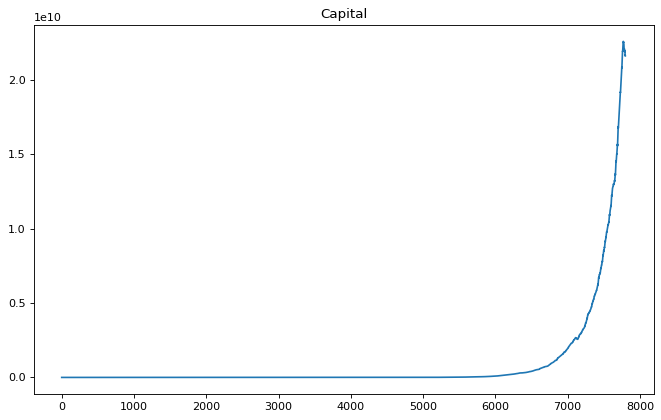

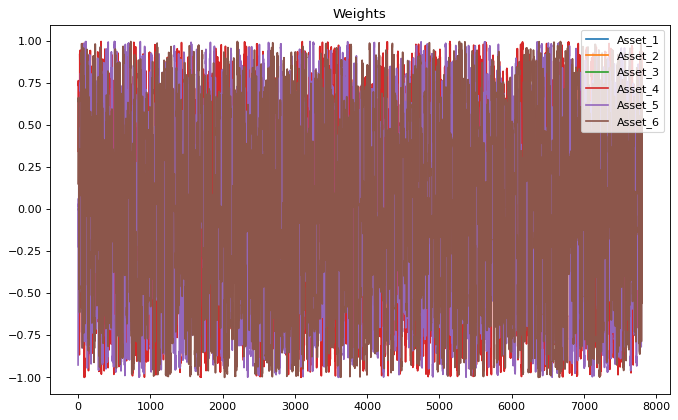

In [328]:
data = pd.read_csv('Case2.csv')
TRAIN, TEST = train_test_split(data, test_size = 0.2, shuffle = False)

def grading(train_data, test_data): 
    '''
    Grading Script
    '''
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = Final_Alloc(train_data)
    for i in range(0,len(test_data)):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")
    
    capital = [1]
    for i in range(len(test_data) - 1):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]
    
    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0
        
    return sharpe, capital, weights

sharpe, capital, weights = grading(TRAIN, TEST)
#Sharpe gets printed to command line
import math
print(sharpe * math.sqrt(7560))

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Capital")
plt.plot(np.arange(len(TEST)), capital)
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Weights")
plt.plot(np.arange(len(TEST)), weights)
plt.legend(TEST.columns)
plt.show()